In [1]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import copia.utils as u
from copia.plot import accumulation_curve
from copia.richness import species_accumulation
from copia.utils import survival_ratio
from copia.plot import multi_kde
from copia.plot import survival_errorbar
from copia.hill import hill_numbers
from copia.utils import evenness
from copia.plot import evenness_plot
from copia.plot import density
from copia.plot import hill_plot
from copia.richness import *

### Load the data

In [2]:
lits = {}
for fn in sorted(glob.glob('../datasets/master/*.xlsx')):
    # keep for later
    if 'anglo-norman' in fn:
        continue
    df = pd.read_excel(fn).dropna(subset = ["title"])
    lang = os.path.basename(fn).replace('.xlsx', '').lower()
    lits[lang] = df[['title', 'signature', 'repository', 'fragmentary']]

### Simple statistics

In [3]:
stats = []
for lit, df in lits.items():
    abundance = u.to_abundance(df['title'])
    s = u.basic_stats(abundance)
    d = {'language': lit}
    for k in ('f1', 'f2', 'S', 'n'):
        d[k] = s[k]
    d['repo'] = len(set(df['repository']))
    stats.append(d)

stats

[{'language': 'dutch', 'f1': 45, 'f2': 13, 'S': 75, 'n': 167, 'repo': 80},
 {'language': 'english', 'f1': 42, 'f2': 8, 'S': 69, 'n': 178, 'repo': 67},
 {'language': 'french', 'f1': 90, 'f2': 21, 'S': 222, 'n': 1473, 'repo': 234},
 {'language': 'german', 'f1': 36, 'f2': 19, 'S': 128, 'n': 1088, 'repo': 389},
 {'language': 'icelandic', 'f1': 44, 'f2': 28, 'S': 117, 'n': 295, 'repo': 12},
 {'language': 'irish', 'f1': 59, 'f2': 49, 'S': 165, 'n': 388, 'repo': 15}]

In [4]:
stats_df = pd.DataFrame(stats)
stats_df['language'] = stats_df['language'].str.lower()
stats_df.loc[len(stats_df)] = ['all'] + list(stats_df[['f1', 'f2', 'S', 'n']].sum()) + [None]
stats_df = stats_df.set_index('language')
stats_df

,f1,f2,S,n,repo
language,,,,,
dutch,45,13,75,167,80
english,42,8,69,178,67
french,90,21,222,1473,234
german,36,19,128,1088,389
icelandic,44,28,117,295,12
irish,59,49,165,388,15
all,316,138,776,3589,None


In [5]:
stats_df['f1/S'] = stats_df['f1'] / stats_df['S']
stats_df['n/S'] = stats_df['n'] / stats_df['S']

stats_df.round(2)

,f1,f2,S,n,repo,f1/S,n/S
language,,,,,,,
dutch,45,13,75,167,80,0.60,2.23
english,42,8,69,178,67,0.61,2.58
french,90,21,222,1473,234,0.41,6.64
german,36,19,128,1088,389,0.28,8.50
icelandic,44,28,117,295,12,0.38,2.52
irish,59,49,165,388,15,0.36,2.35
all,316,138,776,3589,None,0.41,4.62


### Big picture

In [6]:
dfs = []
for lang, df in lits.items():
    df['title'] = [t+'_'+lang for t in df['title']]
    dfs.append(df)

In [7]:
df_all = pd.concat(dfs, ignore_index=True)
df_all

,title,signature,repository,fragmentary
0,Aiol (1)_dutch,"Leiden, UB, BPL 1049; Brussel, KB, IV 816","Leiden, UB ; Brussel, KB",True
1,Aiol (2)_dutch,"Breda, Arch. Begijnhof, z.s.","Breda, Arch. Begijnhof",True
2,Alexanders geesten_dutch,"München, Bayerische Staatsbibliotheek, Cod. ge...","München, Bayerische Staatsbibliotheek",False
3,Alexanders geesten_dutch,"Gent, UB, 2749,6","Gent, UB",True
4,Alexanders geesten_dutch,"Leiden, UB, Ltk. 1196","Leiden, UB",True
...,...,...,...,...
3584,Tucait indarba na nDéssi_irish,TCL MS 1316,"Trinity College, Dublin",None
3585,Tucait indarba na nDéssi_irish,TCL MS 1336,"Trinity College, Dublin",None
3586,Úath Beinne Étair_irish,BL Harley 5280,"British Library, London",None
3587,Úath Beinne Étair_irish,RIA MS 23 N 10,"Royal Irish Academy, Dublin",None


In [8]:
abundance = u.to_abundance(df_all['title'])

100%|██████████| 1000/1000 [00:25<00:00, 39.49it/s]


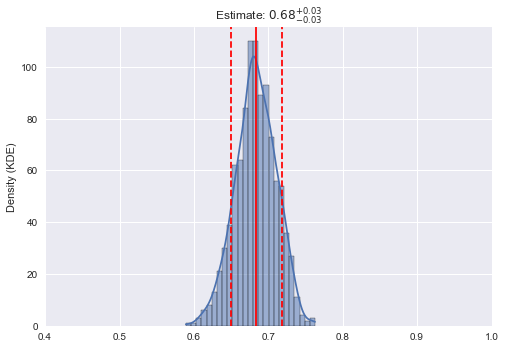

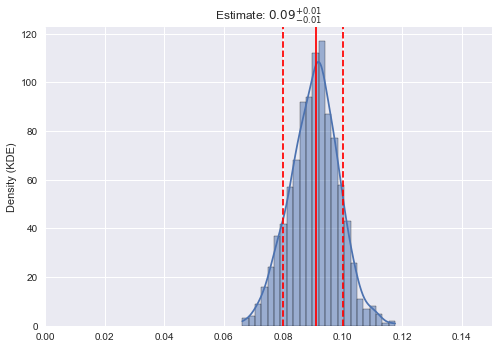

In [9]:
wsurvival_all = survival_ratio(abundance, method='chao1', n_iter=1000)
density(wsurvival_all, xlim=(0.4, 1));
plt.savefig('../outputs/dens_works.pdf')

dsurvival_all = survival_ratio(abundance, method='minsample', n_iter=1000)
density(dsurvival_all, xlim=(0, 0.15))
plt.savefig('../outputs/dens_docs.pdf')

In [10]:
max_steps = 60000
accumulation = species_accumulation(abundance, max_steps=max_steps, n_iter=10)

100%|██████████| 10/10 [03:49<00:00, 22.98s/it]


In [11]:
minsample_est = diversity(abundance, method='minsample', 
                          solver='fsolve', CI=True, n_iter=10)

/Users/mikekestemont/GitRepos/copia/copia/richness.py:422: RuntimeWarning: overflow encountered in exp
  v = lambda x: np.exp(x * (2 * f2 / f1))
/Users/mikekestemont/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/mikekestemont/GitRepos/copia/copia/richness.py:435: UserWarning: Tolerance criterion not met via fsolve: inf > 0.1-> backing off to grid-solver.
  warnings.warn(msg)


Diff_intersect: inf


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


In [12]:
emp, est = hill_numbers(abundance, n_iter=10)

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


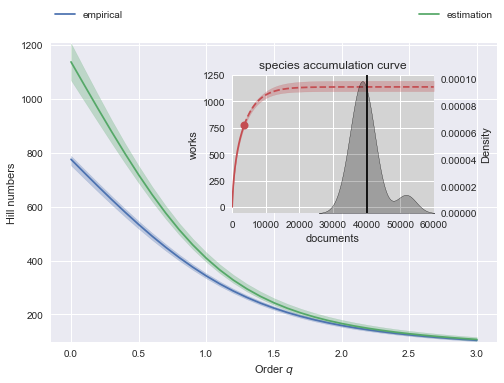

In [13]:
left, bottom, width, height = [0.44, 0.45, 0.35, 0.35]
fig, ax = plt.subplots()

hill_plot(emp, est, add_densities=False, ax=ax)
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_facecolor('lightgrey')

accumulation_curve(abundance, accumulation, c0='C2', c1='black',
                   xlabel='documents', ylabel='works',
                   title='species accumulation curve', ax=ax2,
                   minsample=minsample_est, xlim=(0, max_steps))

plt.savefig('../outputs/all_comb.pdf');

### Per language

In [14]:
assemblages = {}
for lit, df in lits.items():
    abundance = u.to_abundance(df['title'])
    assemblages[lit] = abundance

In [15]:
wsurvival = {}
for category, assemblage in assemblages.items():
    wsurvival[category] = survival_ratio(assemblage, method='chao1')

100%|██████████| 1000/1000 [00:01<00:00, 739.38it/s]


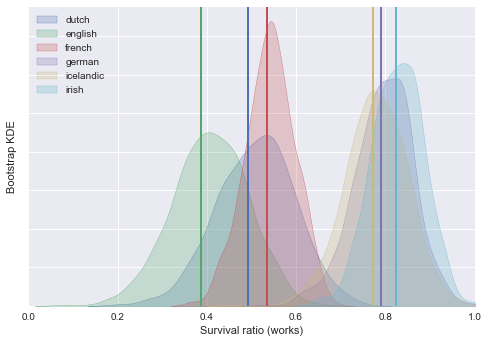

In [16]:
ax = multi_kde(wsurvival)
ax.legend(loc='upper left')
ax.set_xlabel('Survival ratio (works)')
ax.set_ylabel('Bootstrap KDE')
ax.set_yticklabels([])
plt.savefig('../outputs/survival_works_kde.pdf')

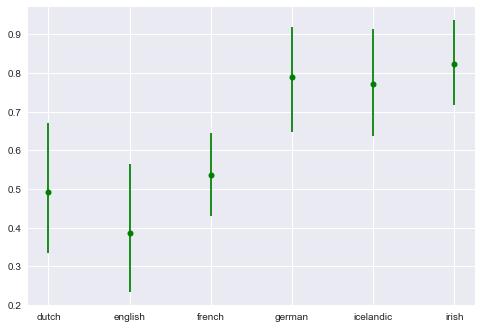

In [17]:
survival_errorbar(wsurvival)
plt.savefig('../outputs/survival_works_error.pdf')

In [18]:
dsurvival = {}
for category, assemblage in assemblages.items():
    dsurvival[category] = survival_ratio(assemblage, method='minsample')

100%|██████████| 1000/1000 [00:26<00:00, 37.90it/s]


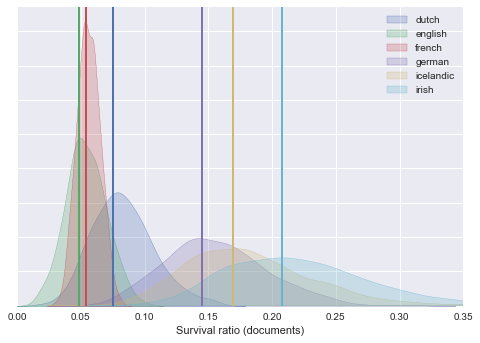

In [19]:
ax = multi_kde(dsurvival)
ax.legend(loc='upper right')
ax.set_xlim((0, 0.35))
ax.set_yticklabels([])
ax.set_xlabel('Survival ratio (documents)')
plt.savefig('../outputs/survival_docs_kde.pdf')

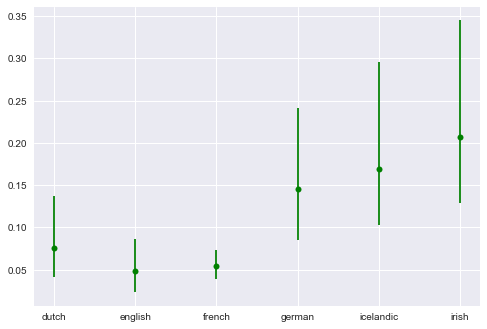

In [20]:
survival_errorbar(dsurvival)
plt.savefig('../outputs/survival_docs_error.pdf')

Big table:

In [21]:
for c in 'CH1 CH1-lCI CH1-uCI MS MS-lCI MS-uCI'.split():
    stats_df[c] = 0.0

stats_df

# for individual languages:
for lang in wsurvival:
    stats_df.loc[lang, 'CH1'] = wsurvival[lang]['survival']
    stats_df.loc[lang, 'CH1-lCI'] = wsurvival[lang]['lci']
    stats_df.loc[lang, 'CH1-uCI'] = wsurvival[lang]['uci']

for lang in dsurvival:
    stats_df.loc[lang, 'MS'] = dsurvival[lang]['survival']
    stats_df.loc[lang, 'MS-lCI'] = dsurvival[lang]['lci']
    stats_df.loc[lang, 'MS-uCI'] = dsurvival[lang]['uci']
    
# for union:
stats_df.loc['all', 'CH1'] = wsurvival_all['survival']
stats_df.loc['all', 'CH1-lCI'] = wsurvival_all['lci']
stats_df.loc['all', 'CH1-uCI'] = wsurvival_all['uci']

stats_df.loc['all', 'MS'] = dsurvival_all['survival']
stats_df.loc['all', 'MS-lCI'] = dsurvival_all['lci']
stats_df.loc['all', 'MS-uCI'] = dsurvival_all['uci']

stats_df.round(3)

,f1,f2,S,n,repo,f1/S,n/S,CH1,CH1-lCI,CH1-uCI,MS,MS-lCI,MS-uCI
language,,,,,,,,,,,,,
dutch,45,13,75,167,80,0.600,2.227,0.492,0.334,0.672,0.075,0.042,0.138
english,42,8,69,178,67,0.609,2.580,0.386,0.233,0.564,0.049,0.023,0.086
french,90,21,222,1473,234,0.405,6.635,0.535,0.429,0.646,0.054,0.039,0.073
german,36,19,128,1088,389,0.281,8.500,0.790,0.649,0.920,0.145,0.085,0.241
icelandic,44,28,117,295,12,0.376,2.521,0.773,0.638,0.914,0.169,0.103,0.296
irish,59,49,165,388,15,0.358,2.352,0.823,0.717,0.936,0.208,0.129,0.345
all,316,138,776,3589,None,0.407,4.625,0.682,0.628,0.733,0.090,0.074,0.106


### Evenness

In [22]:
hill_est = {}
for lang, assemblage in assemblages.items():
    _, est = hill_numbers(assemblage, n_iter=10)
    hill_est[lang] = est

100%|██████████| 10/10 [00:01<00:00,  7.10it/s]


In [23]:
evennesses = {l:evenness(hill_est[l]) for l in hill_est}

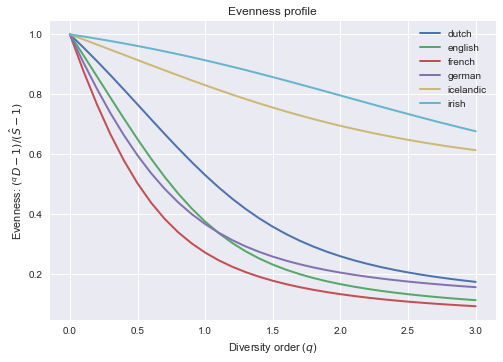

In [24]:
evenness_plot(evennesses)
plt.savefig('../outputs/evenness.pdf')

## Anglo-Norman

In [25]:
an_fn = '../datasets/master/anglo-norman.xlsx'
an = pd.read_excel(an_fn).dropna(subset = ["title"])
an = an[['title', 'signature', 'repository', 'fragmentary']]
an

,title,signature,repository,fragmentary
0,Romance of Horn,"Cambridge, CUL, Ff.vi.17","Cambridge, Cambridge University Library",codex
1,Romance of Horn,"Cambridge, CUL, Add. 4407","Cambridge, Cambridge University Library",fragment
2,Romance of Horn,"Cambridge, CUL, Add. 4470","Cambridge, Cambridge University Library",fragment
3,Romance of Horn,"London, British Library, Harley 527","London, British Library",codex
4,Romance of Horn,"Oxford, Bodleian Library, Douce 132","Oxford, Bodleian Library",codex
...,...,...,...,...
58,Gormont et Isembart,"Brussels, Bibl. Roy., portefeuille II.181",NaN,fragment
59,La destructioun de Rome,"Hannover, Niedersachsische Landesbibl., IV.578",NaN,codex
60,La destructioun de Rome,"London, British Library, Egerton 3028","London, British Library",codex
61,Fierabras,"Hannover, Niedersachsische Landesbibl., IV.578",NaN,codex


100%|██████████| 1000/1000 [00:27<00:00, 36.93it/s]


Text(0.5, 0, 'Survival ratio (documents)')

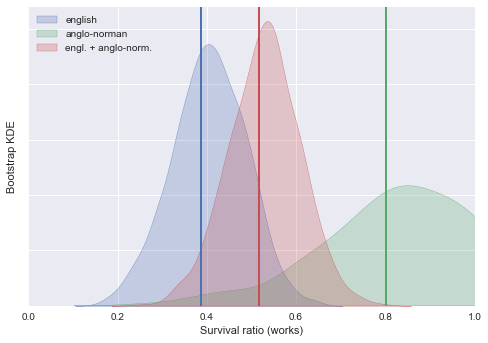

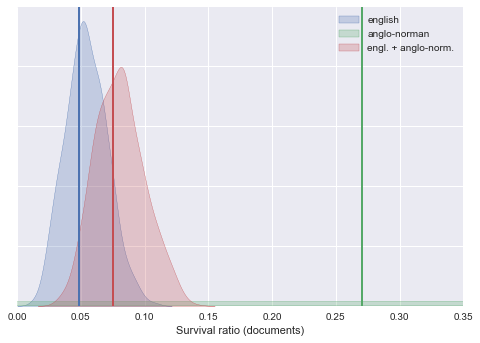

In [27]:
comp = {'english': assemblages['english'],
        'anglo-norman': u.to_abundance(an['title']),
        'engl. + anglo-norm.': np.concatenate((assemblages['english'],
                                              u.to_abundance(an['title'])))
       }
comp

wsurvival = {}
for category, assemblage in comp.items():
    wsurvival[category] = survival_ratio(assemblage, method='chao1')
    
ax = multi_kde(wsurvival)
ax.legend(loc='upper left')
ax.set_xlabel('Survival ratio (works)')
ax.set_ylabel('Bootstrap KDE')
ax.set_yticklabels([]);

dsurvival = {}
for category, assemblage in comp.items():
    dsurvival[category] = survival_ratio(assemblage, method='minsample')
    
ax = multi_kde(dsurvival)
ax.legend(loc='upper right')
ax.set_xlim((0, 0.35))
ax.set_yticklabels([])
ax.set_xlabel('Survival ratio (documents)');

100%|██████████| 1000/1000 [00:26<00:00, 37.50it/s]


Text(0.5, 0, 'Survival ratio (documents)')

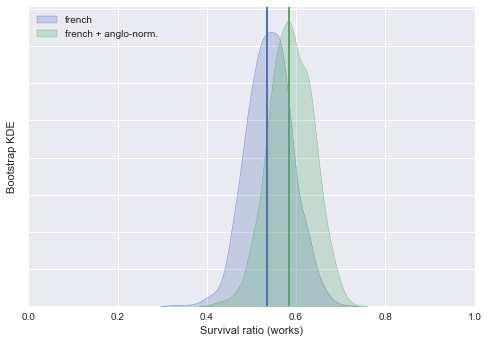

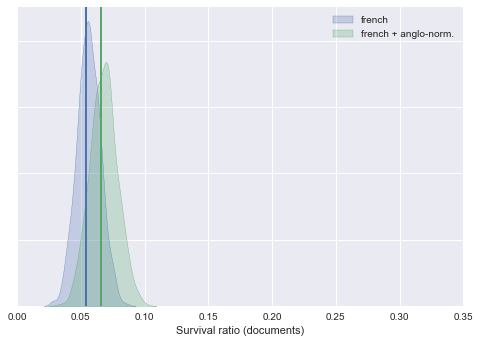

In [28]:
comp = {'french': assemblages['french'],
        'french + anglo-norm.': np.concatenate((assemblages['french'],
                                              u.to_abundance(an['title'])))
       }
wsurvival = {}
for category, assemblage in comp.items():
    wsurvival[category] = survival_ratio(assemblage, method='chao1')
    
ax = multi_kde(wsurvival)
ax.legend(loc='upper left')
ax.set_xlabel('Survival ratio (works)')
ax.set_ylabel('Bootstrap KDE')
ax.set_yticklabels([]);

dsurvival = {}
for category, assemblage in comp.items():
    dsurvival[category] = survival_ratio(assemblage, method='minsample')
    
ax = multi_kde(dsurvival)
ax.legend(loc='upper right')
ax.set_xlim((0, 0.35))
ax.set_yticklabels([])
ax.set_xlabel('Survival ratio (documents)');